# LSTM HW 2
## My steps for task 1

Data Preparation -> Model Architecture -> Tranining Config. -> Epoch Loop Evaulation -> Finetune the hyper parameter of model

Given Data Sets X and Y
X_train shape: (1000, 10, 5), y_train shape: (1000,)
 - 1000 independent sequences, where each sequence contains 10 time steps with 5 features per step.
 - LSTM processes each entire sequence of 10 steps to build an internal understanding, and you use the final output (after the 10th step) to make a single prediction for that sequence.
 -  Each of the 1000 sequences has exactly one corresponding target value in y, making this a "Many-to-One" prediction task, such as classifying an entire sequence or predicting a future value based on the whole sequence.

X_train shape: (1000, 10, 5) -> 1000 samples, each with 10 time steps and 5 features per step.

y shape: (1000,) -> 1000 corresponding labels (one per sample).

I.e.
- Samples (1000): We have 1000 independent time series (or 1000 independent windows of a longer time series).

- Time Steps (10): Each sample has 10 consecutive time steps. This is the length of the sequence we are considering.

- Features (5): At each time step, we have 5 different measurements (e.g., temperature, pressure, etc.) or 5 variables that are observed.

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# 1. Data Preparation
Parameter and Variables:
X input data set shape (1000,10 , 5) 

# How it fit in to the LSTM model:
In PyTorch, the LSTM layer (nn.LSTM) expects the input to be of shape (sequence_length, batch_size, input_size) by default.

Since our X_train is (1000, 10, 5), it matches the batch_first=True format because:
- Input Size (input_size=5): The LSTM expects 5 numbers per time step.
- Sequence Length (sequence_length=10): The LSTM unrolls over 10 time steps for each sample.
- Batch Size (batch_size=1000): The model can process all 1000 sequences simultaneously for efficient training.


In [82]:
# 1. Load data (assuming data is downloaded and saved as .npy files)
X_train = np.load('X.npy')
y_train = np.load('y.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_train shape: {X_test.shape}, y_train shape: {y_test.shape}')
# print head of data
print(f'X_train head: {X_train[1]}')
print(10*'_')
print(f'y_train head: {y_train[:5]}')

X_train shape: (1000, 10, 5), y_train shape: (1000,)
X_train shape: (990, 10, 5), y_train shape: (990,)
X_train head: [[0.84004563 0.9330764  0.17503312 0.05622414 0.1571568 ]
 [0.00488258 0.09579092 0.3278898  0.3145371  0.34238464]
 [0.28460512 0.32179907 0.76360106 0.10422038 0.76808083]
 [0.39255807 0.10342379 0.6579009  0.91408426 0.31042123]
 [0.18209282 0.93380564 0.1103937  0.04231641 0.8953183 ]
 [0.05125725 0.87783635 0.1785408  0.95441204 0.0245602 ]
 [0.51368845 0.59926933 0.97899616 0.4277057  0.67649806]
 [0.40857762 0.25021628 0.13547313 0.3001891  0.783452  ]
 [0.6384614  0.615638   0.6661375  0.17915033 0.45913723]
 [0.01286961 0.7429803  0.38393468 0.46687287 0.08539401]]
__________
y_train head: [0.5028709  0.2839044  0.48828614 0.53908205 0.56725794]


# 2. Data preprocessing


In [83]:
def preprocess_data(X_train, y_train, X_test, y_test):
    """将数据转换为PyTorch张量"""
    # 转换为PyTorch张量
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # 如果y是1D，需要转换为2D (batch_size, 1)
    if len(y_train_tensor.shape) == 1:
        y_train_tensor = y_train_tensor.view(-1, 1)
        y_test_tensor = y_test_tensor.view(-1, 1)
        

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

X_train_tensor,y_train_tensor, X_test_tensor,y_test_tensor  =preprocess_data(X_train, y_train, X_test, y_test)
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)



X_train_tensor shape: torch.Size([1000, 10, 5])
y_train_tensor shape: torch.Size([1000, 1])
X_test_tensor shape: torch.Size([990, 10, 5])
y_test_tensor shape: torch.Size([990, 1])


# 3 Model Architecture
LSTM and Forward architecture

In [84]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        #Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # 初始化隱藏狀態
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # LSTM前向傳播
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # 使用最後一個時間步的輸出
        out = self.fc(lstm_out[:, -1, :])
        return out


In [85]:
class RNNPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # RNN forward pass
        rnn_out, hn = self.rnn(x, h0)
        
        # Use the output of the last time step
        out = self.fc(rnn_out[:, -1, :])
        return out


In [86]:
import torch
import torch.nn as nn

class TransformerPredictor(nn.Module):
    def __init__(self, input_size, num_heads, num_encoder_layers, num_decoder_layers, dim_feedforward, output_size, dropout=0.1):
        super(TransformerPredictor, self).__init__()
        
        # Embedding layer to project input features to the model dimension
        self.input_embedding = nn.Linear(input_size, dim_feedforward)
        
        # Positional encoding to add sequence information
        self.positional_encoding = PositionalEncoding(dim_feedforward, dropout)
        
        # Transformer model
        self.transformer = nn.Transformer(
            d_model=dim_feedforward,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # Ensures input shape is (batch_size, seq_len, feature_dim)
        )
        
        # Fully connected layer to map the output to the desired output size
        self.fc = nn.Linear(dim_feedforward, output_size)
    
    def forward(self, src, tgt):
        # Embed and encode the input and target sequences
        src = self.input_embedding(src)
        tgt = self.input_embedding(tgt)
        
        # Add positional encoding
        src = self.positional_encoding(src)
        tgt = self.positional_encoding(tgt)
        
        # Pass through the Transformer
        transformer_out = self.transformer(src, tgt)
        
        # Apply the final fully connected layer
        out = self.fc(transformer_out)
        return out


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encodings
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)




# 4.1 Epoch training function for LSTM and RNN
I've defined the Model_training here, LSTM & RNN apply same training function ``` train_model ```
Transformer use a different training model

In [87]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
#訓練模型
    train_losses = []
    model.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
           # 前向傳播
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            # 反向傳播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')
    
    return train_losses

## 4.2 Load Data and shuffle into training set 

In [88]:
from torch.utils.data import TensorDataset, DataLoader
# Data loader create
train_dataset_LSTM = TensorDataset(X_train_tensor, y_train_tensor)
train_loader_LSTM = DataLoader(train_dataset_LSTM, batch_size=32, shuffle=True)
#print("DataLoader for LSTM")
#print(train_dataset_LSTM)
#print(y_train_tensor[:5]) 
#print(train_loader_LSTM)


train_dataset_RNN = TensorDataset(X_train_tensor, y_train_tensor)
train_loader_RNN = DataLoader(train_dataset_RNN, batch_size=32, shuffle=True)

train_dataset_transformer = TensorDataset(X_train_tensor, y_train_tensor)
train_loader_transformer = DataLoader(train_dataset_transformer, batch_size=32, shuffle=True)

## 4.3 Hyperparameter for LSTM and RNN(Next cell)
Model hyperparameter can be finetuned here

In [89]:

# 模型參數 Model parameters
input_size_LSTM = X_train.shape[2]  # 特徵dimensionn Feature size
hidden_size_LSTM = 64
#hidden_size = 128
#hidden_size = 32
num_layers_LSTM = 2
output_size_LSTM = 1
    
# 初始化模型
model_LSTM = LSTMPredictor(input_size_LSTM, hidden_size_LSTM, num_layers_LSTM, output_size_LSTM)
    
# 定義損失函數和優化器
criterion_LSTM = nn.MSELoss()
optimizer_LSTM = optim.Adam(model_LSTM.parameters(), lr=0.001)
    
# 開始訓練
print("開始訓練模型...")
num_epochs_LSTM = 100
train_losses_LSTM = train_model(model_LSTM, train_loader_LSTM , criterion_LSTM, optimizer_LSTM, num_epochs_LSTM)
    

開始訓練模型...
Epoch [10/100], Loss: 0.001558
Epoch [20/100], Loss: 0.000225
Epoch [30/100], Loss: 0.000140
Epoch [40/100], Loss: 0.000100
Epoch [50/100], Loss: 0.000118
Epoch [60/100], Loss: 0.000155
Epoch [70/100], Loss: 0.000083
Epoch [80/100], Loss: 0.000096
Epoch [90/100], Loss: 0.000141
Epoch [100/100], Loss: 0.000086


In [90]:
input_size_RNN = 5  # Number of features per time step
hidden_size_RNN = 64  # Number of hidden units
num_layers_RNN = 2  # Number of RNN layers
output_size_RNN = 1  # Output size (e.g., regression or binary classification)


# Initialize the model
model_RNN = RNNPredictor(input_size_RNN, hidden_size_RNN, num_layers_RNN, output_size_RNN)

# Find Error herer the adam need use model_RNN as input
criterion_RNN = nn.MSELoss()
optimizer_RNN = optim.Adam(model_RNN.parameters(), lr=0.001)
    
# 開始訓練
print("開始訓練模型...")
num_epochs_RNN = 100
train_losses_RNN = train_model(model_RNN, train_loader_RNN, criterion_RNN, optimizer_RNN, num_epochs_RNN)
    

開始訓練模型...
Epoch [10/100], Loss: 0.000203
Epoch [20/100], Loss: 0.000123
Epoch [30/100], Loss: 0.000115
Epoch [40/100], Loss: 0.000200
Epoch [50/100], Loss: 0.000173
Epoch [60/100], Loss: 0.000099
Epoch [70/100], Loss: 0.000206
Epoch [80/100], Loss: 0.000114
Epoch [90/100], Loss: 0.000122
Epoch [100/100], Loss: 0.000155


## Train model with transformer architecture

In [91]:
def train_transformer_model(model, train_loader, criterion, optimizer, num_epochs, clip_grad_norm=1.0):
    """
    Train a Transformer model.

    Args:
        model: The Transformer model to train.
        train_loader: DataLoader for the training dataset.
        criterion: Loss function (e.g., nn.MSELoss).
        optimizer: Optimizer (e.g., Adam or AdamW).
        num_epochs: Number of training epochs.
        clip_grad_norm: Maximum norm for gradient clipping.

    Returns:
        train_losses: List of average training losses per epoch.
    """
    train_losses = []
    model.train()  # Set the model to training mode

    for epoch in range(num_epochs):
        epoch_loss = 0

        for batch_x, batch_y in train_loader:
            # Move data to the same device as the model
            batch_x, batch_y = batch_x.to(model.fc.weight.device), batch_y.to(model.fc.weight.device)

            # Prepare the target sequence for the Transformer
            # For regression tasks, the target sequence can be the same as the input
            tgt = batch_x.clone()

            # Forward pass
            outputs = model(batch_x, tgt)
            outputs = outputs[:, -1, :]  # Use the last time step's output for prediction
            loss = criterion(outputs, batch_y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_norm)

            # Optimizer step
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

    return train_losses

## 4.5 Hyperparameter for transformer

In [92]:
# Example usage:
# Define model parameters
input_size_Transformer = 5  # Number of features per time step
num_heads_Transformer = 4  # Number of attention heads
num_encoder_layers_Transformer = 2  # Number of encoder layers
num_decoder_layers_Transformer = 2  # Number of decoder layers
dim_feedforward_Transformer = 128  # Dimension of feedforward network
output_size_Transformer = 1  # Output size (e.g., regression or binary classification)

# Initialize the model
model_Transformer = TransformerPredictor(input_size_Transformer, num_heads_Transformer, num_encoder_layers_Transformer, num_decoder_layers_Transformer, dim_feedforward_Transformer, output_size_Transformer, dropout=0.1)
# Find Error herer the adam need use model_RNN as input
criterion_Transformer = nn.MSELoss()
optimizer_Transformer = optim.Adam(model_Transformer.parameters(), lr=0.001)
model = TransformerPredictor(input_size_Transformer, num_heads_Transformer, num_encoder_layers_Transformer, num_decoder_layers_Transformer, dim_feedforward_Transformer, output_size_Transformer, dropout=0.1)
# Gradient clipping
torch.nn.utils.clip_grad_norm_(model_Transformer.parameters(), max_norm=1.0)
# 開始訓練
print("開始訓練模型...")
num_epochs_Transformer = 100
train_losses_Transformer = train_transformer_model(model_Transformer, train_loader_transformer, criterion_Transformer, optimizer_Transformer, num_epochs_Transformer)
    
# Print the model architecture
print(model)

開始訓練模型...
Epoch [10/100], Loss: 0.005152
Epoch [20/100], Loss: 0.001345
Epoch [30/100], Loss: 0.000814
Epoch [40/100], Loss: 0.001212
Epoch [50/100], Loss: 0.000766
Epoch [60/100], Loss: 0.000897
Epoch [70/100], Loss: 0.000713
Epoch [80/100], Loss: 0.000657
Epoch [90/100], Loss: 0.000609
Epoch [100/100], Loss: 0.000590
TransformerPredictor(
  (input_embedding): Linear(in_features=5, out_features=128, bias=True)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=128, out_features=128, bias=True

# Evaluta

In [93]:
import matplotlib.pyplot as plt
def evaluate_model(model, X_test, y_test):
 #評估模型在測試集上的表現
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        mse = nn.MSELoss()(predictions, y_test)
        
        # 轉換為numpy用於繪圖
        predictions_np = predictions.numpy()
        y_test_np = y_test.numpy()
        
    return mse.item(), predictions_np, y_test_np

def plot_results(train_losses, predictions, true_values, mse):
   # 繪製訓練損失和預測結果
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 繪製訓練損失 
    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.grid(True)
    
    # 繪製預測vs真實值
    ax2.scatter(true_values, predictions, alpha=0.5)
    ax2.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'r--', lw=2)
    ax2.set_title(f'Predictions vs True Values (MSE: {mse:.6f})')
    ax2.set_xlabel('True Values')
    ax2.set_ylabel('Predictions')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('LSTM_results.png', dpi=300, bbox_inches='tight')
    plt.show()


評估模型...
Dataset MSE: 0.000088
Dataset MSE: 0.000079


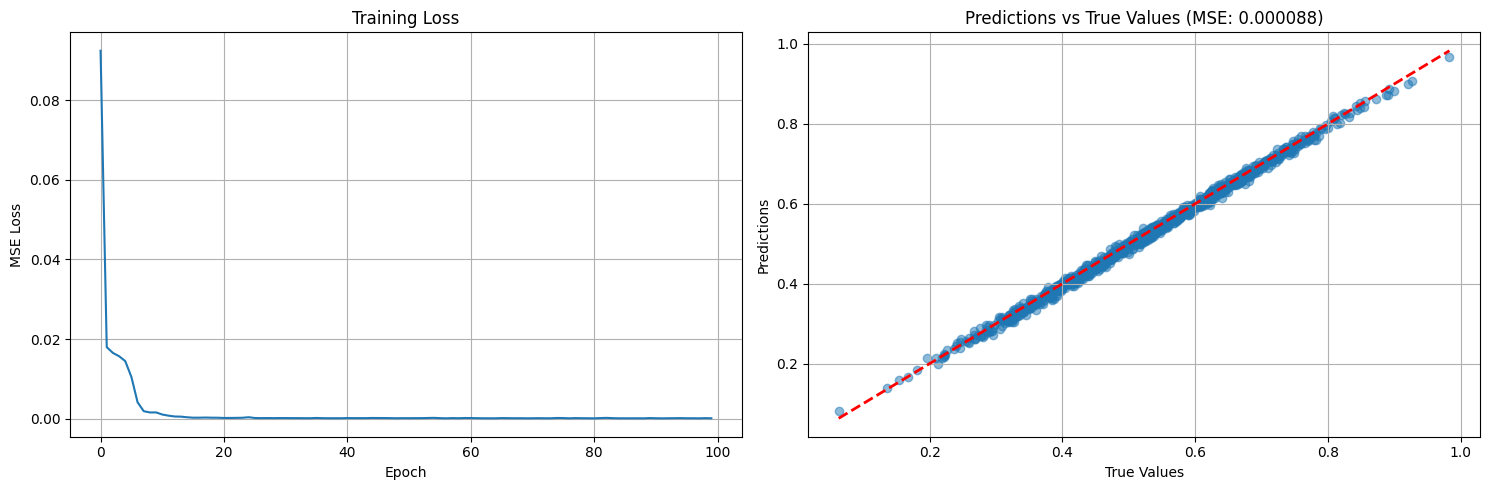

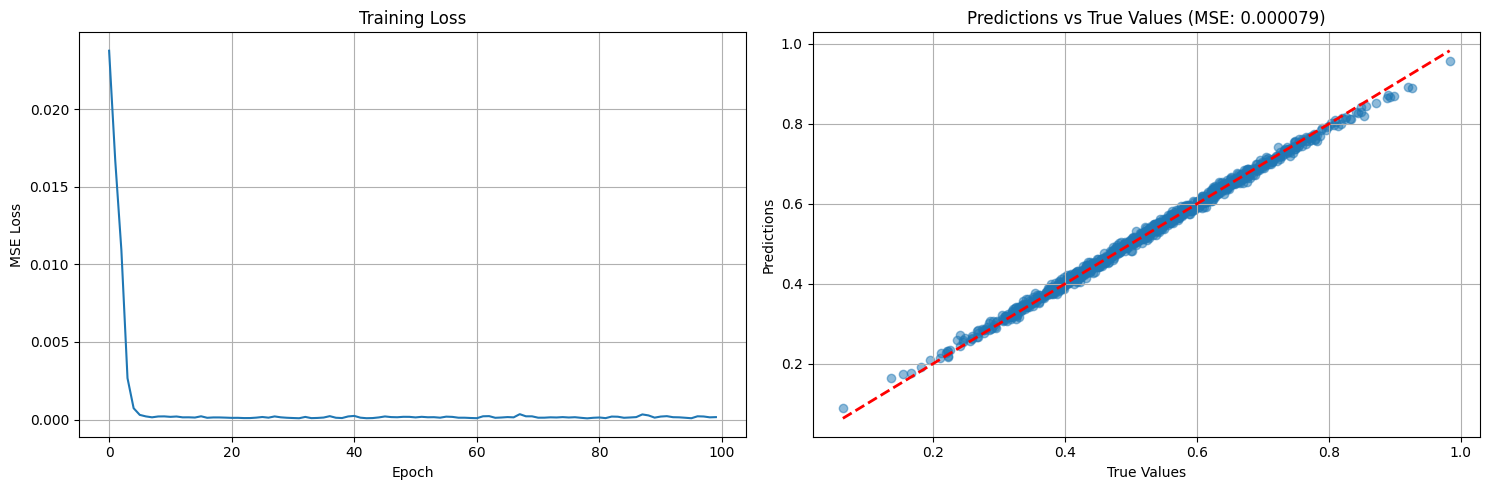

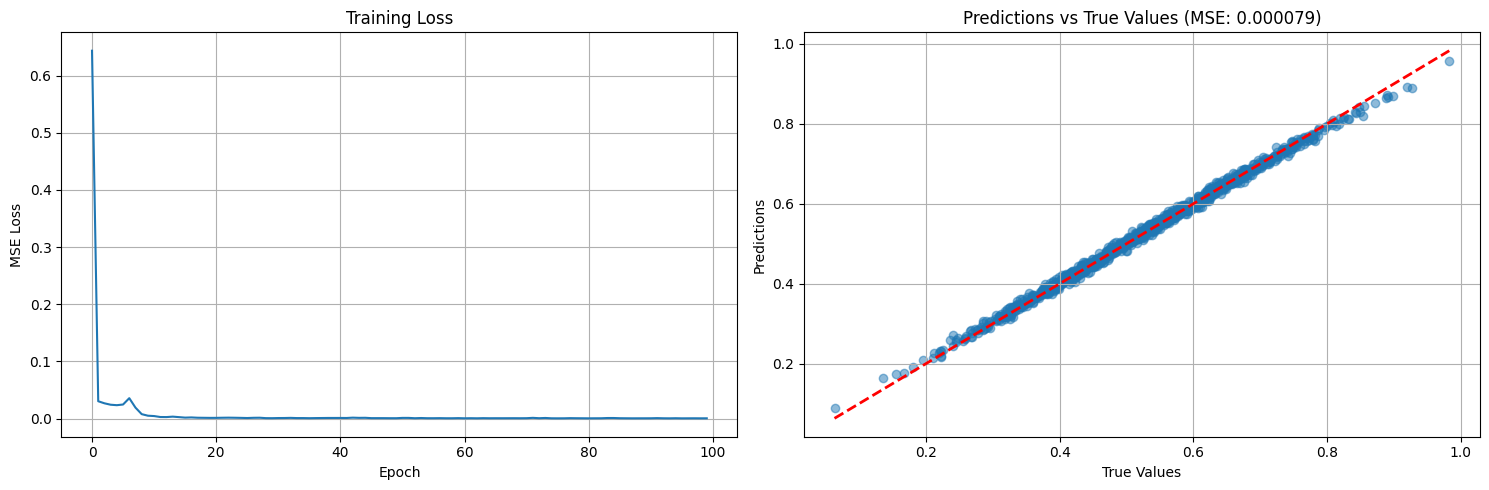

In [95]:
# 評估模型
print("評估模型...")
test_mse, predictions, true_values = evaluate_model(model_LSTM, X_test_tensor, y_test_tensor)
test_mse_RNN, predictions_RNN, true_values_RNN = evaluate_model(model_RNN, X_test_tensor, y_test_tensor)

test_mse_Transformer, predictions_Transformer, true_values_Transformer = evaluate_model(model_RNN, X_test_tensor, y_test_tensor)    
print(f"Dataset MSE: {test_mse:.6f}")
print(f"Dataset MSE: {test_mse_RNN:.6f}")
    
    # 绘制结果
plot_results(train_losses_LSTM, predictions, true_values, test_mse)
plot_results(train_losses_RNN, predictions_RNN, true_values_RNN, test_mse_RNN)
plot_results(train_losses_Transformer, predictions_Transformer, true_values_Transformer, test_mse_Transformer)


### Result
Overfiting occur(prolly), the training loss drop very significatnt
Tranformer has the longest training time
### LHS. 
### RHS. Graph: prediciton vs true value